In [1]:
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

## Prepare data

In [3]:
DATA_DIR = '/home/users/sdunin/calc/TCST'
msa = list(SeqIO.parse(f"{DATA_DIR}/offline_data/hamp/msa/final3.reb2.aln", "fasta"))

In [10]:
full = pd.DataFrame(
        [(str(i.seq).replace('-', ''), i.id) for i in msa],
    columns=['sequence', 'id']
)

In [7]:
short = f'{DATA_DIR}/offline_data/cache/af2_true_full.features.p'
short = pd.read_pickle(short)

In [24]:
def match_sort_with_full(short, full):
    full_seq, full_id = [], []
    for ind, row in short.iterrows():
        has = full[ (full['sequence'].str.contains(row['n_seq'])) &  (full['sequence'].str.contains(row['n_seq']))]
        if not has.empty:
            full_seq.append(has.iloc[0]['sequence'])
            full_id.append(has.iloc[0]['id'])
        else: 
            full_seq.append(None)
            full_id.append(None)
    short = short.assign(full_sequence=full_seq)
    short = short.assign(full_id=full_id)
    short = short.dropna(subset=['full_sequence'])
    return short

In [30]:
def assign_labels(data):
    fulls = []
    for ind, row in data.iterrows(): 
        n_c, c_c = row['n_crick_mut'], row['c_crick_mut']
        n_c, c_c = (n_c[::2] + n_c[1:2])/2, (c_c[::2] + c_c[1:2])/ 2
        full_crick = np.full(len(row['full_sequence']), 10000)
        pos_n = row['full_sequence'].find(row['n_seq'])
        pos_c = row['full_sequence'].find(row['c_seq'])
        full_crick[pos_n+1:pos_n+len(row['n_seq']) - 1] = n_c
        full_crick[pos_c+1:pos_c+len(row['c_seq']) - 1] = c_c
        fulls.append(full_crick)
    data = data.assign(full_crick=fulls)
    return data
        

In [25]:
to_train = match_sort_with_full(short, full)

In [34]:
to_train = assign_labels(to_train)

In [32]:
to_train.to_pickle('../data/input/full_alpha_data.p')

In [48]:
def mse_f1_depend(tr, pred, mi=0.5, unk=1000):
    cov = 0
    prec, rec = 0, 0
    unk_tr, unk_pr =0, 0
    cont = 0
    mse = 0
    for p, c in zip(tr, pred):
        cc = c[0]
        if p != unk:
            unk_tr+=1
        if cc != unk:
            unk_pr +=1
        if p!=unk and cc!=unk:
            cont +=1
            mse += (p - cc) **2
    mse/=cont
    rec = cont/ unk_tr
    prec = cont /unk_pr
    f1 = 2/((1/rec) + (1/prec))
#     print(f1)
    if f1 > mi:
        return mse
    return None
def get_tr_pred(data, unk=1000):
    pr = []
    tr = []
    for ind, row in data.iterrows():
        tpp, tps = [], []
        for t, p in zip(row['true'], row['prediction']):
            if t != unk and p != unk:
                tpp.append(t)
                tps.append(p)
        tr.append(np.mean(tpp))
        pr.append(np.mean(tps))
    return tr, pr
                
    

## Train and validate

In [ ]:
data = pd.read_pickle('../data/input/full_alpha_data.p')
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(140, 140), RadianEncoder(100),  SeqWindow(140, 140, null_char=[[0]]),
                                      parallel=True, n_chains=1, chain_names=('seq', ))
model_conf = model_config = {
    'activation': 'linear',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 1,
    'reshape_out': False,
    'epochs': 100
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
pred = Predictor('hamp_crick_single_sequence', config=conf)
pred.train(data, val_ids=val_ids, ids=idx)

In [19]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'trained' is not defined

In [ ]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validate 

In [46]:
val = data.loc[val_ids]
seqs = list(val.full_sequence)
# res = pred.predict(seqs)
res['true'] = val['full_crick'].values
res['mse_f1']  = res.apply(lambda x: mse_f1_depend(x['true'], x['prediction']), axis=1)
correct = res[res['mse_f1'].notnull()]
len(correct) / len(res)

/tmp/ipykernel_32320/833437755.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]


0.9375

In [49]:
tr, pr = get_tr_pred(correct)

Text(0.5, 1.0, 'Predictions for validation set')

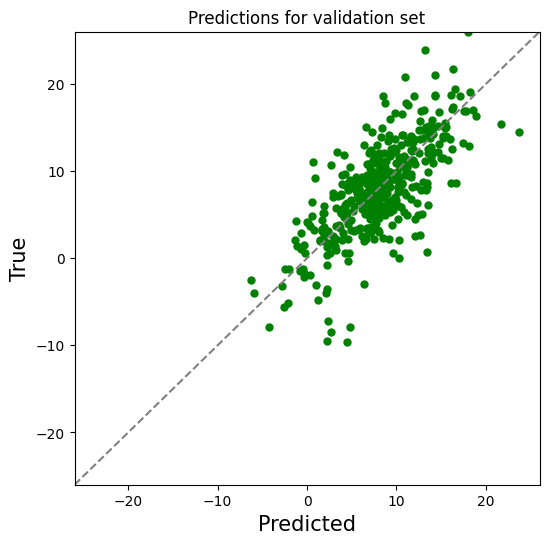

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=25)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('True', size=15)
ax.set_title('Predictions for validation set')